# 2D forced-dissipative turbulence

A simulation of forced-dissipative two-dimensional turbulence. We solve the
two-dimensional vorticity equation with linear drag and stochastic excitation.

In [1]:
using PyPlot, FourierFlows, Printf

using Random: seed!

import GeophysicalFlows.TwoDNavierStokes
import GeophysicalFlows.TwoDNavierStokes: energy, enstrophy, dissipation, work, drag

## Choosing a device: CPU or GPU

In [2]:
dev = CPU()    # Device (CPU/GPU)
nothing # hide

## Numerical, domain, and simulation parameters

First, we pick some numerical and physical parameters for our model.

In [3]:
 n, L  = 256, 2π             # grid resolution and domain length
 ν, nν = 1e-7, 2             # hyperviscosity coefficient and order
 μ, nμ = 1e-1, 0             # linear drag coefficient
dt, tf = 0.005, 0.2/μ        # timestep and final time
    nt = round(Int, tf/dt)   # total timesteps
    ns = 4                   # how many intermediate times we want to plot
nothing # hide

## Forcing

We force the vorticity equation with stochastic excitation that is delta-correlated
in time and while spatially homogeneously and isotropically correlated. The forcing
has a spectrum with power in a ring in wavenumber space of radious $k_f$ and
width $\delta k_f$, and it injects energy per unit area and per unit time equal
to $\varepsilon$.

In [4]:
kf, dkf = 12.0, 2.0     # forcing central wavenumber, wavenumber width
ε = 0.1                 # energy injection rate

gr   = TwoDGrid(dev, n, L)
x, y = gridpoints(gr)

Kr = ArrayType(dev)([ gr.kr[i] for i=1:gr.nkr, j=1:gr.nl])

forcingcovariancespectrum = @. exp(-(sqrt(gr.Krsq)-kf)^2/(2*dkf^2))
forcingcovariancespectrum[gr.Krsq .< 2.0^2 ] .= 0  # making sure that focing has no power for low wavenumbers
forcingcovariancespectrum[gr.Krsq .> 20.0^2 ] .= 0 # making sure that focing has no power for high wavenumbers
forcingcovariancespectrum[Kr .< 2π/L] .= 0
ε0 = FourierFlows.parsevalsum(forcingcovariancespectrum.*gr.invKrsq/2.0, gr)/(gr.Lx*gr.Ly)
forcingcovariancespectrum .= ε/ε0 * forcingcovariancespectrum # normalize forcing to inject energy ε

seed!(1234)
nothing # hide

Next we construct function `calcF!` that computes a forcing realization every timestep

In [5]:
function calcF!(Fh, sol, t, cl, v, p, g)
  eta = ArrayType(dev)(exp.(2π*im*rand(typeof(gr.Lx), size(sol)))/sqrt(cl.dt))
  eta[1, 1] = 0
  @. Fh = eta*sqrt(forcingcovariancespectrum)
  nothing
end
nothing # hide

## Problem setup
We initialize a `Problem` by providing a set of keyword arguments. The
`stepper` keyword defines the time-stepper to be used.

In [6]:
prob = TwoDNavierStokes.Problem(nx=n, Lx=L, ν=ν, nν=nν, μ=μ, nμ=nμ, dt=dt, stepper="RK4",
                        calcF=calcF!, stochastic=true, dev=dev)
nothing # hide

Define some shortcuts for convenience.

In [7]:
sol, cl, v, p, g = prob.sol, prob.clock, prob.vars, prob.params, prob.grid
nothing # hide

## Setting initial conditions

Our initial condition is simply fluid at rest.

In [8]:
TwoDNavierStokes.set_zeta!(prob, 0*x)

## Diagnostics

Create Diagnostics; the diagnostics here will probe the energy budget.

In [9]:
E = Diagnostic(energy,      prob, nsteps=nt) # energy
R = Diagnostic(drag,        prob, nsteps=nt) # dissipation by drag
D = Diagnostic(dissipation, prob, nsteps=nt) # dissipation by hyperviscosity
W = Diagnostic(work,        prob, nsteps=nt) # work input by forcing
diags = [E, D, W, R] # A list of Diagnostics types passed to "stepforward!" will  be updated every timestep.
nothing # hide

## Visualizing the simulation

We define a function that plots the vorticity field and the evolution of
the diagnostics: energy and all terms involved in the energy budget. Last
we confirm whether the energy budget is accurate, i.e., $\mathrm{d}E/\mathrm{d}t = W - R - D$.

In [10]:
function makeplot(prob, diags)
  TwoDNavierStokes.updatevars!(prob)
  E, D, W, R = diags

  t = round(μ*cl.t, digits=2)
  sca(axs[1]); cla()
  pcolormesh(x, y, v.zeta)
  xlabel(L"$x$")
  ylabel(L"$y$")
  title("\$\\nabla^2\\psi(x,y,\\mu t= $t )\$")
  axis("square")

  sca(axs[3]); cla()

  i₀ = 1
  dEdt = (E[(i₀+1):E.i] - E[i₀:E.i-1])/cl.dt #numerical first-order approximation of energy tendency
  ii = (i₀):E.i-1
  ii2 = (i₀+1):E.i

  total = W[ii2] - D[ii] - R[ii]        # Stratonovich interpretation
  residual = dEdt - total

  plot(μ*E.t[ii], W[ii2], label=L"work ($W$)")
  plot(μ*E.t[ii], ε .+ 0*E.t[ii], "--", label=L"ensemble mean  work ($\langle W\rangle $)")
  plot(μ*E.t[ii], -D[ii], label="dissipation (\$D\$)")
  plot(μ*E.t[ii], -R[ii], label=L"drag ($D=2\mu E$)")
  plot(μ*E.t[ii], 0*E.t[ii], "k:", linewidth=0.5)
  ylabel("Energy sources and sinks")
  xlabel(L"$\mu t$")
  legend(fontsize=10)

  sca(axs[2]); cla()
  plot(μ*E.t[ii], total[ii], label=L"computed $W-D$")
  plot(μ*E.t[ii], dEdt, "--k", label=L"numerical $dE/dt$")
  ylabel(L"$dE/dt$")
  xlabel(L"$\mu t$")
  legend(fontsize=10)

  sca(axs[4]); cla()
  plot(μ*E.t[ii], residual, "c-", label=L"residual $dE/dt$ = computed $-$ numerical")
  xlabel(L"$\mu t$")
  legend(fontsize=10)
end
nothing # hide

## Time-stepping the `Problem` forward

Finally, we time-step the `Problem` forward in time.

In [11]:
startwalltime = time()
for i = 1:ns
  stepforward!(prob, diags, round(Int, nt/ns))
  TwoDNavierStokes.updatevars!(prob)
  cfl = cl.dt*maximum([maximum(v.u)/g.dx, maximum(v.v)/g.dy])

  log = @sprintf("step: %04d, t: %.1f, cfl: %.3f, walltime: %.2f min", cl.step, cl.t,
        cfl, (time()-startwalltime)/60)

  println(log)
end

step: 0100, t: 0.5, cfl: 0.174, walltime: 0.05 min
step: 0200, t: 1.0, cfl: 0.246, walltime: 0.07 min
step: 0300, t: 1.5, cfl: 0.262, walltime: 0.09 min
step: 0400, t: 2.0, cfl: 0.347, walltime: 0.12 min


## Plot
And now let's see what we got. We plot the output.

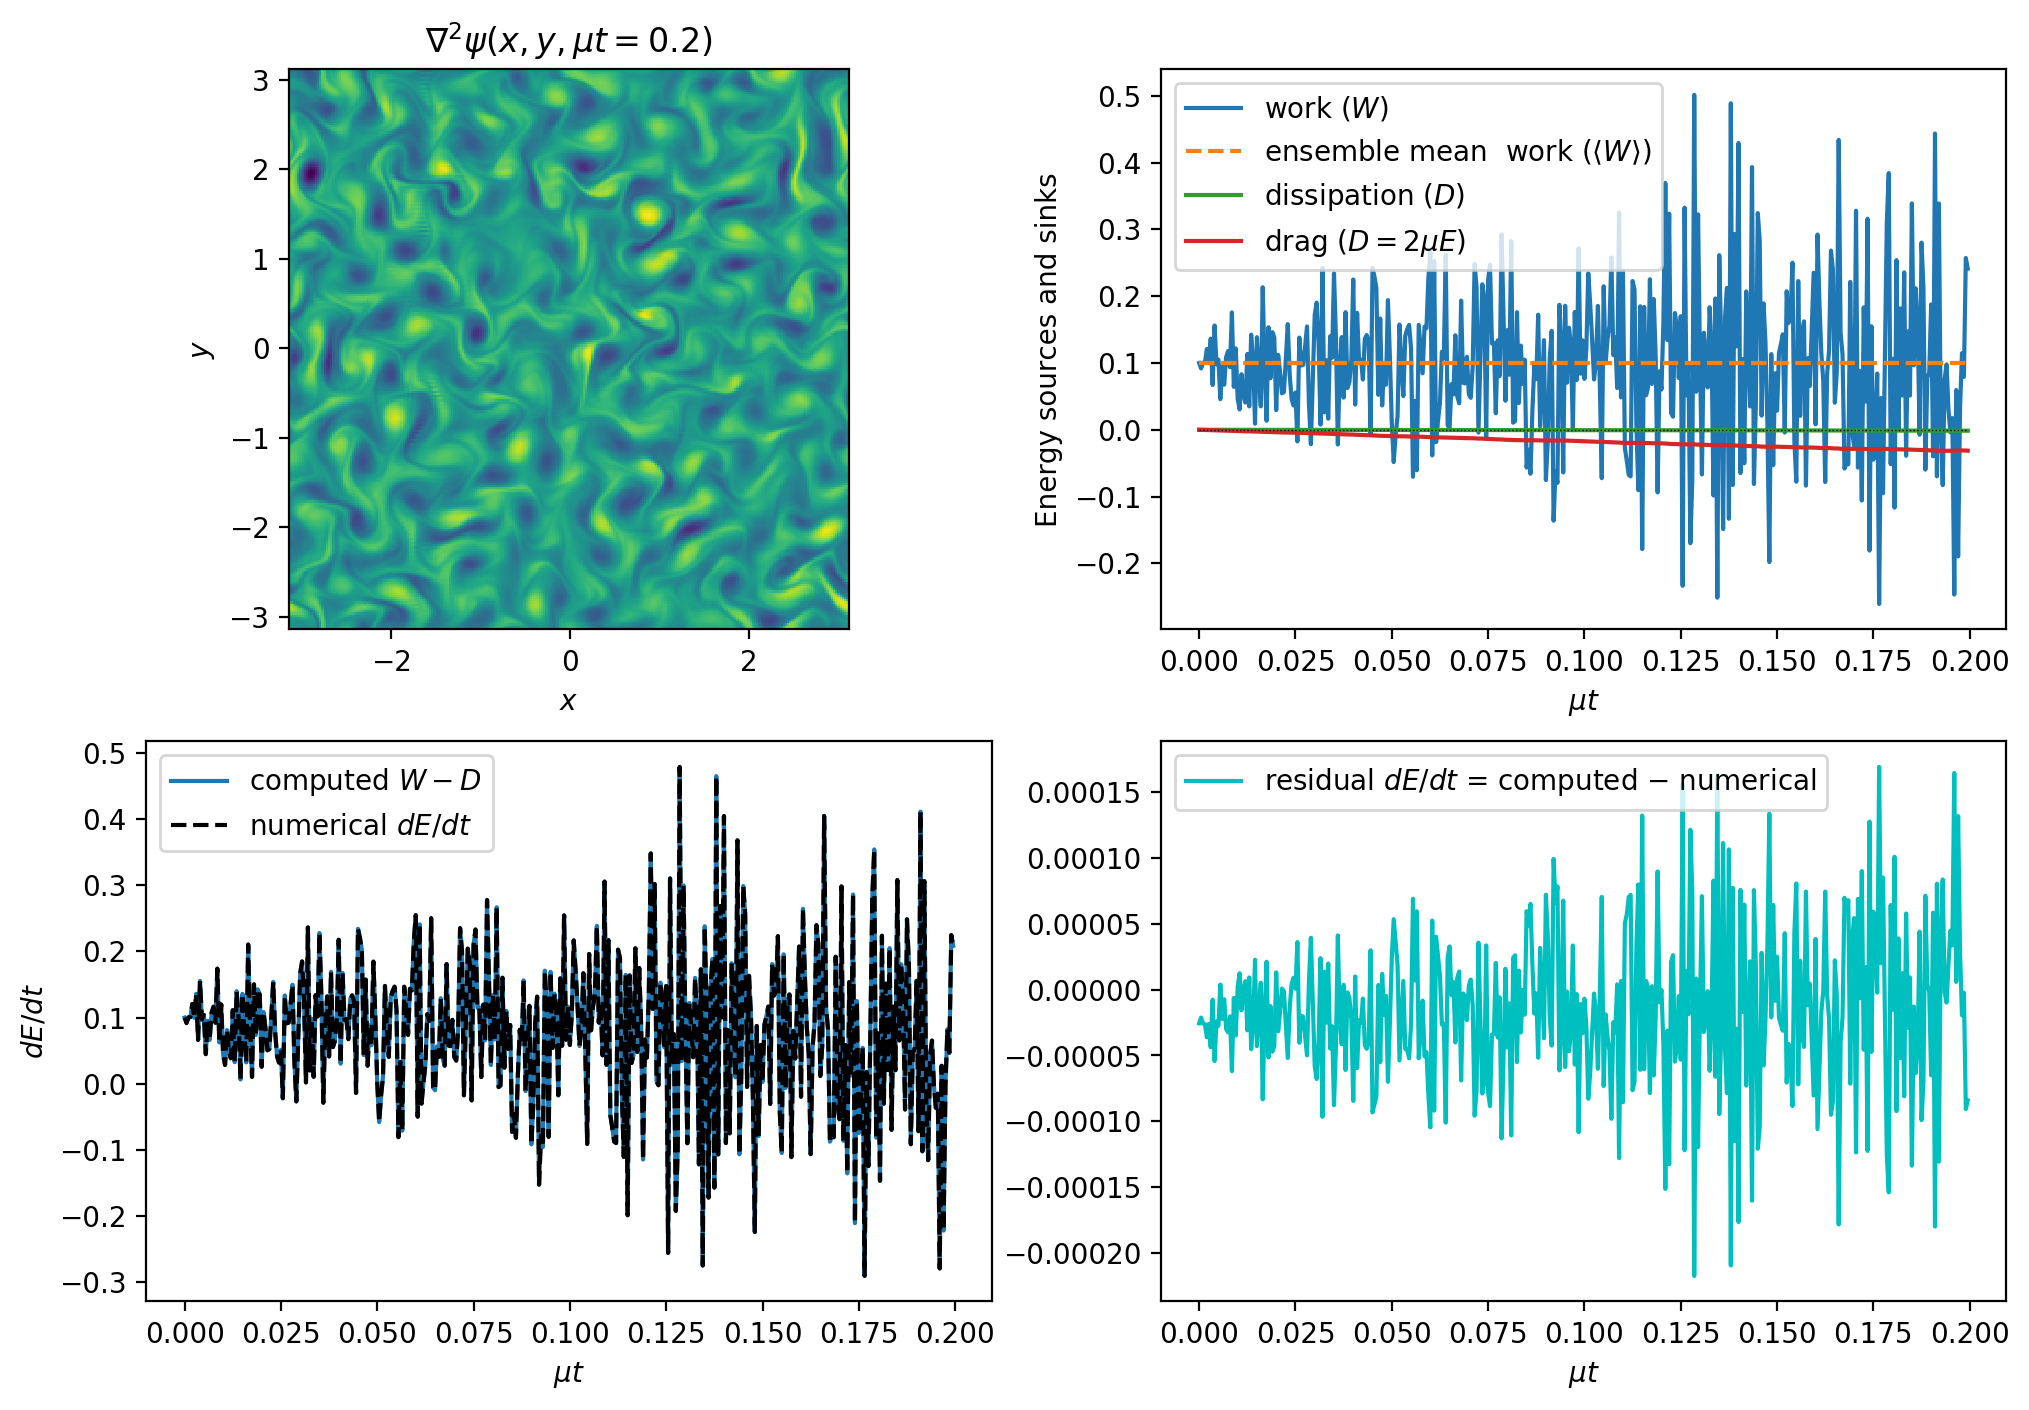

In [12]:
fig, axs = subplots(ncols=2, nrows=2, figsize=(12, 8), dpi=200)
makeplot(prob, diags)
gcf() # hide

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*